# 2. Data Preparation
📒 `2.0-rc-data-preparation.ipynb`

**Objetivo:** Transformar os dados brutos em um formato para uso em análise exploratória e modelagem.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Utils
from src._utils import detect_outliers_iqr, analyze_outliers,  plot_distribution_and_boxplot

# Ignore warnings
warnings.filterwarnings('ignore')

# Configura o matplotlib para mostrar gráficos inline
%matplotlib inline

# Setup para mostrar todas as colunas do dataframe
pd.set_option('display.max_columns', None)

## 1. Limpeza dos Dados


### a) Remove colunas desnecessárias e renomeia as colunas e classes

In [2]:
# Carrega dados
df = pd.read_csv("../data/raw/bootcamp_train.csv")
print( "N° de linhas e colunas: ", df.shape)
df.head()

N° de linhas e colunas:  (35260, 15)


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não


In [3]:
# Deleta as colunas que não são necessárias
df.drop(columns=['id', 'id_produto'], inplace=True)

# Renomeia as colunas
cols_to_rename = {
    'tipo': 'tipo',
    'temperatura_ar': 'temperatura_ar',
    'temperatura_processo': 'temperatura_processo',
    'umidade_relativa': 'umidade_relativa',
    'velocidade_rotacional': 'velocidade_rotacional',
    'torque': 'torque',
    'desgaste_da_ferramenta': 'desgaste_da_ferramenta',
    'falha_maquina': 'falha_maquina',
    'FTE (Falha Tensao Excessiva)': 'Tensao Excessiva(FTE)',
    'FDC (Falha Dissipacao Calor)': 'Dissipacao de Calor(FDC)',
    'FP (Falha Potencia)': 'Falha de Potencia(FP)',
    'FDF (Falha Desgaste Ferramenta)': 'Desgaste da Ferramenta(FDF)',
    'FA (Falha Aleatoria)': 'Falha Aleatoria(FA)'
}

# Renomeia as colunas
df.rename(columns=cols_to_rename, inplace=True)


### Renomeia as classes da coluna `tipo` para facilitar a interpretação
dict_type = {
    'L': 'Baixa', 
    'M': 'Media', 
    'H': 'Alta'
    }
# Aplica o mapeamento
df['tipo'] = df['tipo'].map(dict_type)


# Visualiza as 5 primeiras linhas
print( "N° de linhas e colunas: ", df.shape)
print("Visualiza as 5 primeiras linhas:")
df.head()


N° de linhas e colunas:  (35260, 13)
Visualiza as 5 primeiras linhas:


,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,Desgaste da Ferramenta(FDF),Dissipacao de Calor(FDC),Falha de Potencia(FP),Tensao Excessiva(FTE),Falha Aleatoria(FA)
0,Baixa,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,Baixa,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,Baixa,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,Media,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,Baixa,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não



### b) Valores Nulos

In [4]:
# Verifica dados Nulos
df.isnull().sum()

tipo                             0
temperatura_ar                 616
temperatura_processo           599
umidade_relativa                 0
velocidade_rotacional          751
torque                         623
desgaste_da_ferramenta         952
falha_maquina                    0
Desgaste da Ferramenta(FDF)      0
Dissipacao de Calor(FDC)         0
Falha de Potencia(FP)            0
Tensao Excessiva(FTE)            0
Falha Aleatoria(FA)              0
dtype: int64

In [5]:
# Tratando Valores Nulos
# Preenchimento de valores ausentes com a mediana ( menos sensivel aos outliers)

num_cols_to_inspect = [
    'temperatura_ar', 
    'temperatura_processo', 
    'umidade_relativa', 
    'velocidade_rotacional', 
    'torque', 
    'desgaste_da_ferramenta'
    ]

for col in num_cols_to_inspect:
    df[col].fillna(df[col].median(), inplace=True)

print("Valores Nulos tratados com a mediana: \n", df.isnull().sum())


Valores Nulos tratados com a mediana: 
 tipo                           0
temperatura_ar                 0
temperatura_processo           0
umidade_relativa               0
velocidade_rotacional          0
torque                         0
desgaste_da_ferramenta         0
falha_maquina                  0
Desgaste da Ferramenta(FDF)    0
Dissipacao de Calor(FDC)       0
Falha de Potencia(FP)          0
Tensao Excessiva(FTE)          0
Falha Aleatoria(FA)            0
dtype: int64


### c) Inconsistência nos dados

In [6]:
# Verifica dados Inconsistentes
print("Descrição dos dados numéricos: \n", df.describe())
print("-"*50)

for col in num_cols_to_inspect:
    print(df.loc[df[col] < 0, col].value_counts())
    print("\n")

# Trata Inconsistências com a mediana
for col in num_cols_to_inspect:
    df.loc[df[col] < 0, col] = df[col].median()

print("Inconsistências tratadas!")

Descrição dos dados numéricos: 
        temperatura_ar  temperatura_processo  umidade_relativa  \
count    35260.000000          35260.000000      35260.000000   
mean       270.060479            280.956146         89.997672   
std         95.578134             96.191402          0.142191   
min        -36.000000            -38.000000         80.590429   
25%        298.000000            308.500000         90.000000   
50%        299.600000            309.800000         90.000000   
75%        301.000000            310.900000         90.000000   
max        304.500000            313.800000         94.575256   

       velocidade_rotacional        torque  desgaste_da_ferramenta  
count           35260.000000  35260.000000            35260.000000  
mean             1382.383834     40.211941               74.903176  
std               489.033715      8.753262              108.957614  
min              -161.000000      3.800000             -202.000000  
25%              1411.000000     34.

In [7]:
# Verifica dados de classes com inconsistências
cols_to_inspect = [
    'falha_maquina', 
    'Desgaste da Ferramenta(FDF)', 
    'Dissipacao de Calor(FDC)', 
    'Falha de Potencia(FP)', 
    'Tensao Excessiva(FTE)', 
    'Falha Aleatoria(FA)'
    ]

# Verifica valores únicos em todas as colunas
for col in cols_to_inspect:
    print(f"Coluna: {col}")
    print(f"Valores únicos: {df[col].unique()}")
    print(f"Quantidade de valores únicos: {df[col].nunique()}")
    print("-"*50)


Coluna: falha_maquina
Valores únicos: ['não' 'Não' 'sim' 'N' '0' 'Sim' 'y' '1']
Quantidade de valores únicos: 8
--------------------------------------------------
Coluna: Desgaste da Ferramenta(FDF)
Valores únicos: ['False' 'N' '0' 'True' '-' '1']
Quantidade de valores únicos: 6
--------------------------------------------------
Coluna: Dissipacao de Calor(FDC)
Valores únicos: ['False' 'nao' '0' 'True' 'y' '1']
Quantidade de valores únicos: 6
--------------------------------------------------
Coluna: Falha de Potencia(FP)
Valores únicos: ['Não' 'não' 'Sim' 'N' '0' 'sim' '1' 'y']
Quantidade de valores únicos: 8
--------------------------------------------------
Coluna: Tensao Excessiva(FTE)
Valores únicos: [False  True]
Quantidade de valores únicos: 2
--------------------------------------------------
Coluna: Falha Aleatoria(FA)
Valores únicos: ['Não' 'não' '0' '-' 'Sim' 'sim' '1']
Quantidade de valores únicos: 7
--------------------------------------------------


In [8]:
# Dicionário de mapeamento para padronizar valores binários
map_classes = {
    # Valores que representam "0" (não/falso)
    'não': '0',
    'Não': '0',
    'N': '0',
    'False': '0',
    'false': '0',
    'nao': '0',
    '-': '0',
    # Valores que representam "1" (sim/verdadeiro)
    'sim': '1',
    'Sim': '1',
    'y': '1',
    'True': '1',
    'true': '1'
}

# Lista de colunas para aplicar a transformação
cols_to_transform = [
    'falha_maquina',
    'Desgaste da Ferramenta(FDF)',
    'Dissipacao de Calor(FDC)',
    'Falha de Potencia(FP)',
    'Tensao Excessiva(FTE)',
    'Falha Aleatoria(FA)'
]

# Aplica a transformação em cada coluna
for col in cols_to_transform:
    df[col] = df[col].astype(str)
    # Aplica o mapeamento
    df[col] = df[col].map(lambda x: map_classes.get(x, x))
    # Converte a coluna para tipo numérico
    df[col] = pd.to_numeric(df[col])

# Verifica os valores únicos após a transformação
print("Verificação após a transformação:")
print("-" * 50)
for col in cols_to_transform:
    print(f"Coluna: {col}")
    print(f"Valores únicos: {df[col].unique()}")
    print(f"Quantidade: {df[col].nunique()}")
    print("-" * 50)



Verificação após a transformação:
--------------------------------------------------
Coluna: falha_maquina
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: Desgaste da Ferramenta(FDF)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: Dissipacao de Calor(FDC)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: Falha de Potencia(FP)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: Tensao Excessiva(FTE)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------
Coluna: Falha Aleatoria(FA)
Valores únicos: [0 1]
Quantidade: 2
--------------------------------------------------


In [9]:
# Dicionário de mapeamento para o tipo de falha com os novos nomes das colunas
dict_tipo_falha = {
    'Desgaste da Ferramenta(FDF)': 'Desgaste da Ferramenta(FDF)', 
    'Dissipacao de Calor(FDC)': 'Dissipacao de Calor(FDC)', 
    'Falha de Potencia(FP)': 'Falha de Potencia(FP)', 
    'Tensao Excessiva(FTE)': 'Tensao Excessiva(FTE)', 
    'Falha Aleatoria(FA)': 'Falha Aleatoria(FA)'
}

# Função para determinar o tipo de falha usando os novos nomes
def get_tipo_falha(row):
    # Verifica cada coluna de falha
    for col in dict_tipo_falha.keys():
        try:
            if row[col] == 1:
                return dict_tipo_falha[col]
        except KeyError:
            continue
    return "Sem falhas"

# Criar a nova coluna tipo_falha
df['tipo_falha'] = df.apply(get_tipo_falha, axis=1)

# Verificar a distribuição dos tipos de falha
print("\nDistribuição dos tipos de falha:")
print(df['tipo_falha'].value_counts())


# Verificando se há inconsistências na classificação
#df[(df['falha_maquina'] == 1) & (df['tipo_falha'] == 'Sem falhas')]



Distribuição dos tipos de falha:
tipo_falha
Sem falhas                     34612
Dissipacao de Calor(FDC)         225
Tensao Excessiva(FTE)            155
Falha de Potencia(FP)            124
Falha Aleatoria(FA)               73
Desgaste da Ferramenta(FDF)       71
Name: count, dtype: int64


### d) Dados Duplicados

In [10]:
print("Dados Duplicados removidos: ", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Dados Duplicados removidos:  56


### e) Análise de Outliers

Análise da distribuição das variáveis numéricas:


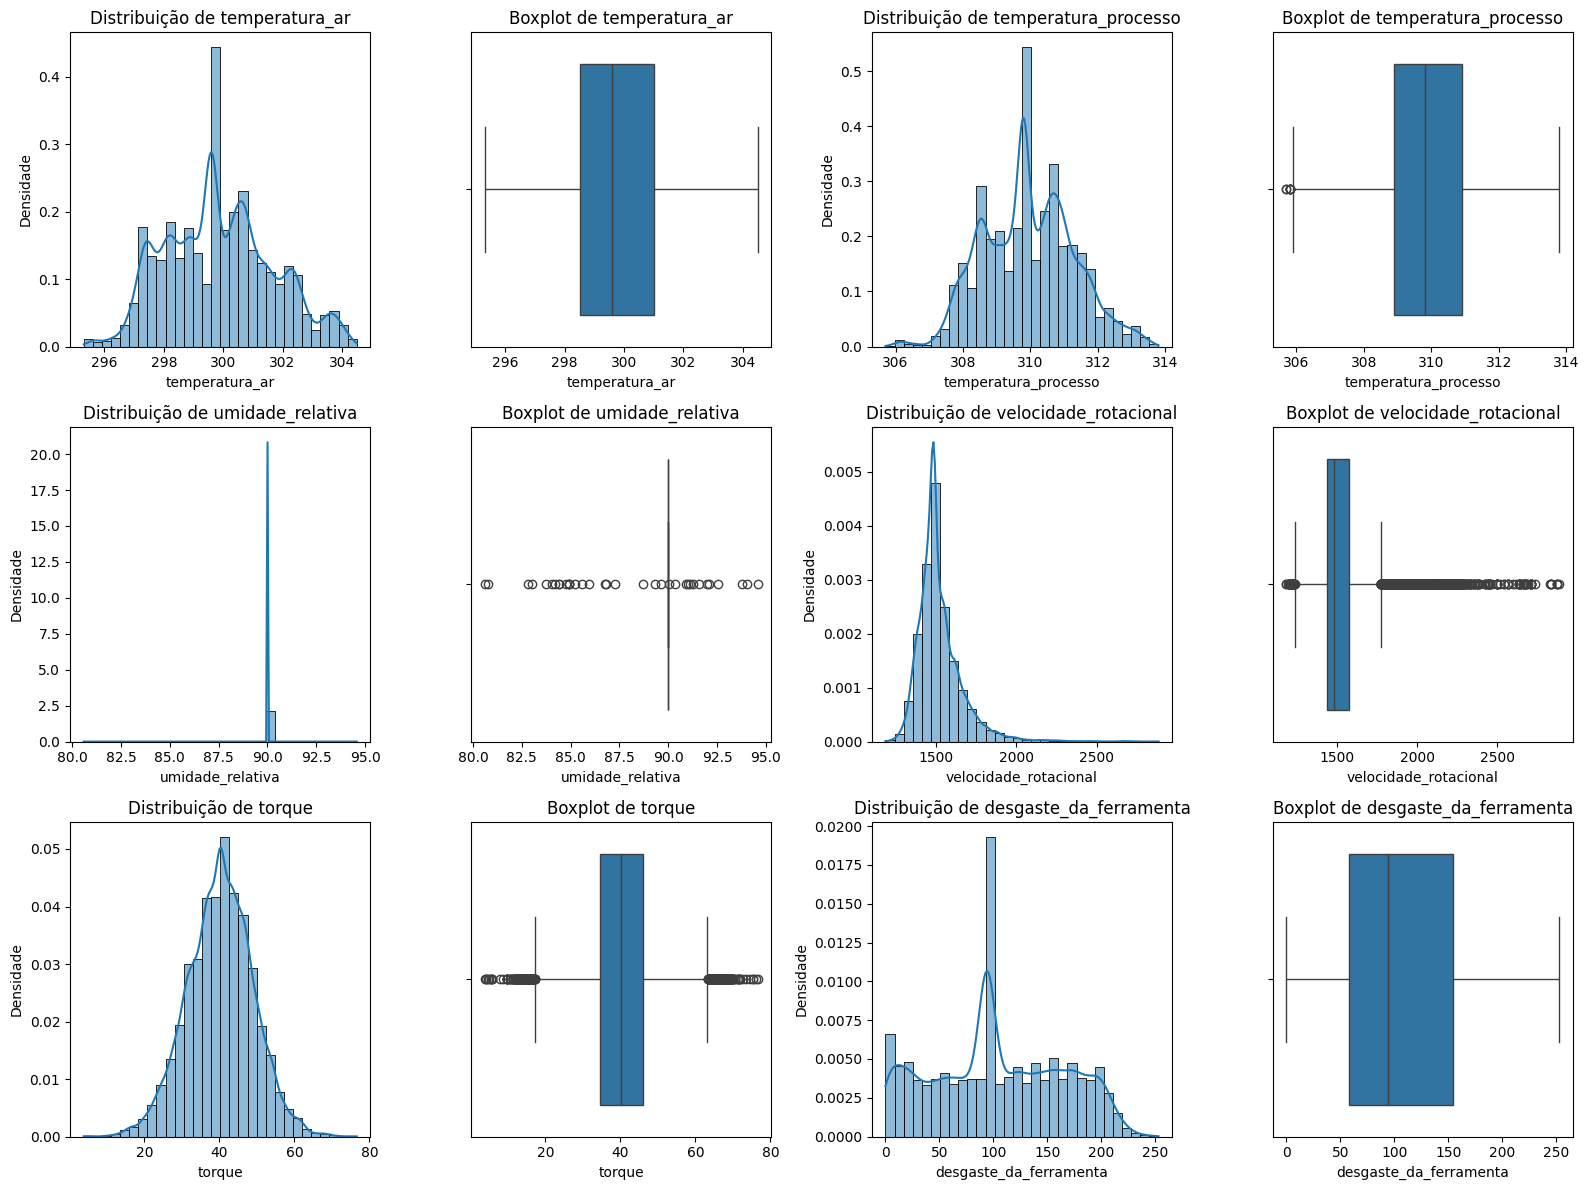


Estatísticas descritivas das variáveis numéricas:
       temperatura_ar  temperatura_processo  umidade_relativa  \
count    35204.000000          35204.000000      35204.000000   
mean       299.870412            309.945941         89.997668   
std          1.791149              1.333926          0.142304   
min        295.300000            305.700000         80.590429   
25%        298.500000            308.900000         90.000000   
50%        299.600000            309.800000         90.000000   
75%        301.000000            310.900000         90.000000   
max        304.500000            313.800000         94.575256   

       velocidade_rotacional        torque  desgaste_da_ferramenta  
count           35204.000000  35204.000000            35204.000000  
mean             1520.817947     40.207903              103.775594  
std               142.670884      8.752899               59.971828  
min              1183.000000      3.800000                0.000000  
25%              1

<Figure size 640x480 with 0 Axes>

In [12]:
# Análise da distribuição das variáveis numéricas
print("Análise da distribuição das variáveis numéricas:")

# Declarando as colunas alvo
target_cols = ['falha_maquina', 'Falha Aleatoria(FA)', 'Falha de Potencia(FP)', 'Tensao Excessiva(FTE)', 'Dissipacao de Calor(FDC)', 'Desgaste da Ferramenta(FDF)']

# Seleciona as colunas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(target_cols).tolist()

# Plotar a distribuição e o boxplot das variáveis numéricas
plot_distribution_and_boxplot(df, numeric_cols)

# Mostrar estatísticas descritivas
print("\nEstatísticas descritivas das variáveis numéricas:")
print(df[numeric_cols].describe())

# Salvar o gráfico com melhor qualidade
plt.savefig('../reports/figures/2_data_preparation_outliers', 
            bbox_inches='tight', 
            dpi=300)


In [15]:
# máscara acumulada de "é outlier em QUALQUER coluna"
any_outlier = pd.Series(False, index=df.index)

for col in numeric_cols:
    mask, stats = detect_outliers_iqr(df[col], col)
    any_outlier |= mask  # acumula outliers

# remover linhas que são outlier em qualquer coluna
df_clean = df.loc[~any_outlier].copy()

print(f"Linhas originais: {len(df)}")
print(f"Linhas removidas (outliers): {any_outlier.sum()}")
print(f"Linhas após limpeza: {len(df_clean)}")

# Análise resumida
outlier_analysis = analyze_outliers(df_clean, numeric_cols) 
print(outlier_analysis.to_string(index=False))


Linhas originais: 35204
Linhas removidas (outliers): 2024
Linhas após limpeza: 33180
                column  n_outliers  percentage_outliers  lower_bound  upper_bound
        temperatura_ar           0             0.000000       294.75       304.75
  temperatura_processo          33             0.099458       306.05       313.65
      umidade_relativa           0             0.000000        90.00        90.00
 velocidade_rotacional         609             1.835443      1253.50      1737.50
                torque          87             0.262206        19.55        62.35
desgaste_da_ferramenta           0             0.000000       -86.00       298.00


#### Remoção da variável de umidade relativa

NOta: A variável `umidade_relativa` não possui variação, possui pouca informação sobre os dados de falha, sendo assim, **esta variável será removida dos estudos.**

In [16]:
df_clean.drop(columns=['umidade_relativa'], inplace=True)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33180 entries, 0 to 35259
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   tipo                         33180 non-null  object 
 1   temperatura_ar               33180 non-null  float64
 2   temperatura_processo         33180 non-null  float64
 3   velocidade_rotacional        33180 non-null  float64
 4   torque                       33180 non-null  float64
 5   desgaste_da_ferramenta       33180 non-null  float64
 6   falha_maquina                33180 non-null  int64  
 7   Desgaste da Ferramenta(FDF)  33180 non-null  int64  
 8   Dissipacao de Calor(FDC)     33180 non-null  int64  
 9   Falha de Potencia(FP)        33180 non-null  int64  
 10  Tensao Excessiva(FTE)        33180 non-null  int64  
 11  Falha Aleatoria(FA)          33180 non-null  int64  
 12  tipo_falha                   33180 non-null  object 
dtypes: float64(5), int64(

#### Reordena as colunas e reseta index

In [17]:
# Reset Index
df_clean.reset_index(drop=True, inplace=True)

# Reordena as colunas
cols_to_reorder = [
    'tipo', 
    'temperatura_ar', 
    'temperatura_processo', 
    'velocidade_rotacional', 
    'torque', 
    'desgaste_da_ferramenta', 
    'falha_maquina', 
    'tipo_falha',
    'Desgaste da Ferramenta(FDF)',
    'Dissipacao de Calor(FDC)',
    'Falha de Potencia(FP)',  
    'Tensao Excessiva(FTE)',
    'Falha Aleatoria(FA)',
    ]

# Reordena as colunas
df_clean = df_clean[cols_to_reorder]

# Salva o dataset tratado
path_to_save = "../data/processed/data_cleaned.csv"
df_clean.to_csv(path_to_save, index=False)

### Visualiza os Dados Limpos com Pandas Profile Report

In [18]:
# Visualiza os dados pós tratamento com Pandas Profiling
from ydata_profiling import ProfileReport

FILE_PATH = "../reports/profile-reports/data_cleaned.html"

profile = ProfileReport(
    df_clean,
    title="Profiling Report - Dados Tratados"
)

# Salva HTML estático
profile.to_file(FILE_PATH)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 282.59it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
# visualizar inline
profile.to_notebook_iframe()
print(f"Relatório salvo em: {FILE_PATH}")

Relatório salvo em: ../reports/profile-reports/data_cleaned.html


## 2. Pré Processamento

In [21]:
# === Imports ===
import os
import numpy as np
import pandas as pd

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from joblib import dump

# Configuração
RANDOM_SEED = 42

In [22]:
# Carrega o dataset tratado
df = pd.read_csv('../data/processed/data_cleaned.csv')

# Colunas a excluir de X para evitar vazamento de informação
cols_excluir = [
    'tipo_falha',                     
    'falha_maquina',                   
    'Falha de Potencia(FP)', 
    'Dissipacao de Calor(FDC)', 
    'Tensao Excessiva(FTE)', 
    'Desgaste da Ferramenta(FDF)', 
    'Falha Aleatoria(FA)'
]

# 1) Seleciona os atributos (X) e a variável alvo (y)
X = df.drop(columns=[c for c in cols_excluir if c in df.columns]).copy()
y = df['falha_maquina'].copy()


# 2) Identifica e seleciona os atributos numéricos e categóricos
numeric_cols   = X.select_dtypes(include=[np.number]).columns.tolist()
categoric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# 3) Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_SEED,
    stratify=y
)

# 4) Monta transformadores apenas se houver colunas do tipo
transformers = []
if numeric_cols:
    transformers.append(('num', StandardScaler(), numeric_cols))
if categoric_cols:
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), categoric_cols))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop'  # descarta qualquer coluna não transformada (por segurança)
)


# Infos adicionais
print(f"Alvo (y): {y.name} — tipo: {y.dtype}")
print("\nAtributos Numéricos (X):", numeric_cols if numeric_cols else "— (nenhum)")
print("\nAtributos Categóricos (X):", categoric_cols if categoric_cols else "— (nenhum)")

print("\nDistribuição das classes (dataset completo):")
print(y.value_counts(normalize=True).rename('proporcao').mul(100).round(2).astype(str) + '%')



Alvo (y): falha_maquina — tipo: int64

Atributos Numéricos (X): ['temperatura_ar', 'temperatura_processo', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']

Atributos Categóricos (X): ['tipo']

Distribuição das classes (dataset completo):
falha_maquina
0    98.45%
1     1.55%
Name: proporcao, dtype: object


### Salva Artefatos

In [23]:
# Persistência dos dados tratados
os.makedirs('../models/artifacts', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../data/interim', exist_ok=True)

# Salvar os splits para manter os dados tratados
X_train.to_csv('../data/interim/X_train.csv', index=False)
X_test.to_csv('../data/interim/X_test.csv', index=False)
y_train.to_csv('../data/interim/y_train.csv', index=False)
y_test.to_csv('../data/interim/y_test.csv', index=False)

# Salvar “especificação” do pré-processamento (listas de colunas + objeto definido/sem ajuste)
dump({
    "numeric_cols": numeric_cols,
    "categorical_cols": categoric_cols,
    "preprocessor": preprocessor,
    "random_seed": RANDOM_SEED,
    "target_name": "tipo_falha",
    "target_vars_all": cols_excluir,
    # utilidades para referência futura
    "classes_": sorted(y.unique().tolist()),
    "class_distribution_full": y.value_counts(normalize=True).to_dict()
}, "../models/artifacts/preprocessing_spec.joblib")

print("\nArtefatos salvos em ../models/artifacts e splits em ../data/interim.")



Artefatos salvos em ../models/artifacts e splits em ../data/interim.
